# Applying Data Science Models

In [1]:
#data imports
import pandas as pd
import numpy as np

#data science imports
from sklearn.model_selection import cross_val_score,GridSearchCV,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.decomposition import NMF,PCA
from sklearn.metrics import accuracy_score, r2_score
import statsmodels.api as sm

#plotting imports
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.9f' % x)

C:\Users\rich.wolff\AppData\Local\Continuum\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Joins and Data Frame builds

In [2]:
## Import pre cleaned data
data = pd.read_csv('../data/cleansed/data.csv',index_col=0).set_index('uniqueid')
locations = pd.read_csv('../data/cleansed/locations.csv')

In [3]:
# join locations data
tidy_data = data.join(locations.set_index('uniqueid')[['geographiclevel','stateabbr','cityname']]).copy()

# Only keep census level data
tidy_data = tidy_data[tidy_data['geographiclevel'] == 'Census Tract']

# Drop uneeded columns
tidy_data = tidy_data.drop(['datavaluetypeid','geographiclevel','stateabbr','cityname'],axis=1).reset_index().set_index('uniqueid')

In [4]:
# Check data 
tidy_data.head()

,populationcount,ACCESS2,ARTHRITIS,BINGE,BPHIGH,BPMED,CANCER,CASTHMA,CHD,CHECKUP,...,KIDNEY,LPA,MAMMOUSE,MHLTH,OBESITY,PAPTEST,PHLTH,SLEEP,STROKE,TEETHLOST
uniqueid,,,,,,,,,,,,,,,,,,,,,
0107000-01073000100,3042.000000000,0.239000000,0.325000000,0.101000000,0.462000000,0.800000000,0.052000000,0.127000000,0.080000000,0.763000000,...,0.036000000,0.423000000,0.742000000,0.188000000,0.467000000,0.760000000,0.196000000,0.504000000,0.055000000,0.302000000
0107000-01073000300,2735.000000000,0.288000000,0.313000000,0.108000000,0.456000000,0.803000000,0.046000000,0.118000000,0.082000000,0.738000000,...,0.038000000,0.437000000,0.740000000,0.185000000,0.470000000,0.732000000,0.202000000,0.494000000,0.057000000,0.333000000
0107000-01073000400,3338.000000000,0.261000000,0.346000000,0.095000000,0.501000000,0.820000000,0.052000000,0.130000000,0.088000000,0.775000000,...,0.040000000,0.449000000,0.736000000,0.191000000,0.488000000,0.728000000,0.211000000,0.525000000,0.065000000,0.360000000
0107000-01073000500,2864.000000000,0.281000000,0.378000000,0.086000000,0.543000000,0.840000000,0.058000000,0.134000000,0.108000000,0.788000000,...,0.048000000,0.471000000,0.732000000,0.194000000,0.499000000,0.708000000,0.231000000,0.526000000,0.082000000,0.402000000
0107000-01073000700,2577.000000000,0.318000000,0.385000000,0.074000000,0.554000000,0.833000000,0.057000000,0.143000000,0.119000000,0.787000000,...,0.057000000,0.508000000,0.705000000,0.216000000,0.528000000,0.676000000,0.258000000,0.541000000,0.096000000,0.458000000


<h2>Now that the data is in a tidy format, I'll split the data into a train and test group. The model will be built on the training data and the test data will be held out for a final general fit test</h2>

In [5]:
# Set variables into X and y with y being the target and X being the features.
zscore = lambda x: (x-x.mean())/x.std()
tidy_data_scaled = tidy_data #.transform(zscore,axis=0)

y = tidy_data['OBESITY']
X = tidy_data.drop('OBESITY',axis=1)

# Separate data into train test split
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size=.25,random_state=21)

<h2> Next, we can fit all the features to our model to see if there are any features we could focus on. My goal is to bring the features down to what explains the mode</h2>

In [6]:
m0 = sm.OLS(ytrain,Xtrain).fit()
print(m0.summary())

                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.379e+05
Date:                Tue, 10 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:30:07   Log-Likelihood:                 48660.
No. Observations:               20398   AIC:                        -9.726e+04
Df Residuals:                   20370   BIC:                        -9.704e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
populationcount -1.259e-07   8.33e-08     

<H2> Looking at the initial results, there are 3 values with high pvalues. Populationcount, poor mental health, and having lost teeth do not add much information to this model and will be dropped </H2>

In [7]:
# Drop features with higher pvalues
drop_high_pval = np.array(['populationcount','MHLTH','TEETHLOST'])
Xtrain_dropped = Xtrain.drop(drop_high_pval,axis=1)

# Retrain model without dropped features
m1 = sm.OLS(ytrain,Xtrain_dropped).fit()
print('AIC Change: {0:.4f}'.format(m1.aic-m0.aic))
print(m1.summary())

AIC Change: -0.5810
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.544e+05
Date:                Tue, 10 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:30:08   Log-Likelihood:                 48657.
No. Observations:               20398   AIC:                        -9.726e+04
Df Residuals:                   20373   BIC:                        -9.707e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ACCESS2          0.1781     

<h3>After we dropped those three features, we actually saw an AIC drop and it is probably fair to leave them out. It's also good to note that our R^2 did not change either.</h3>

<h3>Next, Ill look at the coefficients to decipher which has the most affect on the model and whether or no that makes sense (Is a population with high Obesity % that way because they have high blood pressure, or do they have high blood pressure because they're obese?</h3>

In [8]:
#Set the alpha for confidence interval sizes
alpha = .05

#Obtain Coefficient confidence intervals
conf_ints = m1.conf_int(alpha=alpha)
conf_ints.columns =['low','high']
conf_ints.sort_values('high',ascending=False)

,low,high
KIDNEY,2.312893564,2.775174768
COPD,0.796059372,0.948358392
BPHIGH,0.663624526,0.705894198
CASTHMA,0.441383585,0.552737343
ARTHRITIS,0.491007909,0.541346620
DIABETES,0.365248731,0.481102829
PAPTEST,0.299767393,0.328370276
LPA,0.252989648,0.283959782
CSMOKING,0.210323958,0.252452294
BINGE,0.215034675,0.246098882


<p>It's no surprise to see High Blood Pressure (BPHIGH), Kidney Disease, and Arthritis high up on this list. According to the CDC<sup>1</sup>, these are all effects of being obese. What's extremely interesting is CHD (coronary heart disease) ranks as a strong indicator of populations low in obesity. Also, an outcome of Reported poor physical health is a strong indicator of populations with low obesity. The two data data series have a .89 correlation. I'll drop this one as well.</p>

<p>Next, I'll remove those items typically associated as effects as obesity to see if we can narrow down some causes that may be closer to causing obesity</p>

<p><sup>1</sup><a href='https://www.cdc.gov/healthyweight/effects/index.html'>CDC: The Health Effects of Overweight and Obesity</a></p>

In [9]:
# Drop features with higher pvalues
drop_effects_of_obesity = np.array(['CHD','BPHIGH','ARTHRITIS','DIABETES','HIGHCHOL','PHLTH','KIDNEY','STROKE'])
Xtrain_dropped = Xtrain.drop(np.concatenate([drop_effects_of_obesity,drop_high_pval]),axis=1)

# Retrain model without dropped features
m2 = sm.OLS(ytrain,Xtrain_dropped).fit()
print('AIC Change: {0:.4f}'.format(m2.aic-m1.aic))
print(m2.summary())

AIC Change: 14789.8278
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.093e+05
Date:                Tue, 10 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:30:08   Log-Likelihood:                 41255.
No. Observations:               20398   AIC:                        -8.248e+04
Df Residuals:                   20381   BIC:                        -8.234e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
ACCESS2          0.0326  

<h2> First, we see a drop in R2 from .995 to .989 and an AIC increase of 14789. This seems like a big increase but I'm willing to include it to reduce the noise from variables that are typically an effect of what we're trying to predict</h2>

<h2> Second, We now see that the p value for populations with a higher % of colon_screenings and a higher % of binge drinking. Let's remove that and see what the outcome of these variables are</h2>

In [10]:
drop_high_pval2 = np.array(['BINGE','COLON_SCREEN'])
Xtrain_dropped = Xtrain.drop(np.concatenate([drop_effects_of_obesity,drop_high_pval,drop_high_pval2]),axis=1)

# Retrain model without dropped features
m3 = sm.OLS(ytrain,Xtrain_dropped).fit()
print('AIC Change: {0:.4f}'.format(m3.aic-m2.aic))
print(m3.summary())

AIC Change: -1.3431
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.239e+05
Date:                Tue, 10 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:30:08   Log-Likelihood:                 41253.
No. Observations:               20398   AIC:                        -8.248e+04
Df Residuals:                   20383   BIC:                        -8.236e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ACCESS2        0.0352      0.006

<h2>We saw a tiny decrease to AIC and no change to our R^2</H2>

<h3>Let's look at our coefficients</h3>

In [11]:
#Set the alpha for confidence interval sizes
alpha = .05

#Obtain Coefficient confidence intervals
conf_ints = m3.conf_int(alpha=alpha)
conf_ints.columns =['low','high']
conf_ints.sort_values('high',ascending=False)

,low,high
CASTHMA,0.621850651,0.742809070
CSMOKING,0.397214678,0.445847121
PAPTEST,0.223031849,0.259492818
LPA,0.215645616,0.254335557
BPMED,0.218996327,0.247159740
CANCER,0.028865204,0.166892003
MAMMOUSE,0.102622583,0.137949917
COREW,0.094223728,0.126570871
ACCESS2,0.024244223,0.046084625
COREM,0.004462104,0.038575359


<H2> Some findings jump out off the screen. 1.) 2 out of 4 of the top 4 predictive features of populations with high obesity are negative behaviours. Being a smoker and having asthma are high predictive features of high obesity. The 5th, taking Blood pressure medication could be due to the correlation between obesity and high blood pressure, hence those populations would take blood pressure medication.</H2>

<H3> There are a couple features which don't make a sense to me. First, populations that have had higher rates of pap smear tests among those who didn't have a hysterectomy are a strong indicator of high obesity. Contextually, this doesn't fit. Also, Populations with higher rates of COPD are indicators of lower rates of obesity. This could be due to collinearity</H3> 

<H4> I'd like to do a couple things at this point. Remove features that dont make sense contextually to increasing Obesity (Having a papsmear test, a mammogram, or the correlation between BPMED and OBESITY) and then perform a PCA to remove some of the collinearity that may be happening.</H4>

In [12]:
drop_noncontext= np.array(['MAMMOUSE','PAPTEST','BPMED'])
Xtrain_dropped = Xtrain.drop(np.concatenate([drop_effects_of_obesity,drop_high_pval,drop_high_pval2,drop_noncontext]),axis=1)

# Retrain model without dropped features
m4 = sm.OLS(ytrain,Xtrain_dropped).fit()
print('AIC Change: {0:.4f}'.format(m4.aic-m3.aic))
print(m4.summary())

AIC Change: 2153.1789
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 1.392e+05
Date:                Tue, 10 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:30:08   Log-Likelihood:                 40174.
No. Observations:               20398   AIC:                        -8.032e+04
Df Residuals:                   20386   BIC:                        -8.023e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ACCESS2        0.1654      0.0

<h2> We see a small drop in R2 from .989 to .988 and an AIC increase of 2153. It's not as bad as some of the other drops but it is fairly large.

We still see COPD as a strong indicator of low obesity, in which the correlation between Obestity and COPD is high (.75). Let's perform PCA to see if we can reduce some collinearity.</h2>

In [13]:
#Initialize and fit NMF
pca = PCA()
pca.fit(Xtrain_dropped)
Xtrain_PCA = pca.transform(Xtrain_dropped)
pca.explained_variance_ratio_

array([  7.14813208e-01,   1.27158725e-01,   5.99467694e-02,
         4.41207999e-02,   1.80706697e-02,   1.16031691e-02,
         8.55377211e-03,   6.68148811e-03,   5.85873662e-03,
         1.94021698e-03,   8.50057960e-04,   4.02386421e-04])

In [14]:
# Retrain model without dropped features
m5 = sm.OLS(ytrain,Xtrain_PCA).fit()
print('AIC Change: {0:.4f}'.format(m5.aic-m4.aic))
print(m5.summary())

AIC Change: 88950.6349
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     99.73
Date:                Tue, 10 Apr 2018   Prob (F-statistic):          1.44e-241
Time:                        09:30:09   Log-Likelihood:                -4301.7
No. Observations:               20398   AIC:                             8627.
Df Residuals:                   20386   BIC:                             8722.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2875      0.

<h2> PCA has no value to this data. Lets Try NFM </h2>

In [15]:
nmf = NMF()
Xtrain_NMF = nmf.fit_transform(Xtrain_dropped)

# Retrain model with NMF
m5 = sm.OLS(ytrain,Xtrain_NMF).fit()
print('AIC Change: {0:.4f}'.format(m5.aic-m4.aic))
print(m5.summary())

AIC Change: 1467.9027
                            OLS Regression Results                            
Dep. Variable:                OBESITY   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 1.294e+05
Date:                Tue, 10 Apr 2018   Prob (F-statistic):               0.00
Time:                        09:30:11   Log-Likelihood:                 39440.
No. Observations:               20398   AIC:                        -7.886e+04
Df Residuals:                   20386   BIC:                        -7.876e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0618      0.0

<h2>It looks like there are three features that are most important to the model. Let's select them to see which inputs to the NMF are important to those Features</h2>

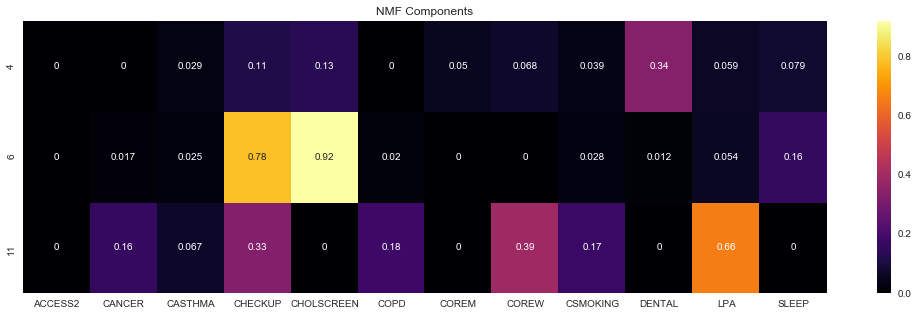

In [16]:
import seaborn as sns
fig = plt.figure(figsize=(18,5))
sns.heatmap(pd.DataFrame(nmf.components_,columns=Xtrain_dropped.columns).iloc[[4,6,11],:],annot=True,cmap='inferno')
plt.title('NMF Components')

<h2> Access to health insurance seems to be an important input as it hits two of these high effecient features. We also see some of the other causes that we noted earlier like low physical activity, being a smoker, and having asthma. It's interesting to note that Sleep is now coming in as well in the feature that has the highest coefficients</h2>

In [17]:
def scorer(model,X,y):
    model.fit(X,y)
    ypred = model.predict(X)
    return r2_score(y,ypred)

lr = LinearRegression()
lr.fit(Xtrain_dropped,ytrain)
print('Cross Fold Validation with untouched data')
print('Linear Regression R2: {:.4f}'.format(lr.score(Xtrain_dropped,ytrain)))
print('Linear Regression Cross Val Score: {}'.format(cross_val_score(lr,Xtrain_dropped,ytrain,cv=5,scoring=scorer)))
pd.DataFrame(lr.coef_,index=Xtrain_dropped.columns,columns=['Coefs']).sort_values('Coefs',ascending=False).T

Cross Fold Validation with untouched data
Linear Regression R2: 0.8267
Linear Regression Cross Val Score: [ 0.82175699  0.82753836  0.83009496  0.83033927  0.82593027]


,CASTHMA,CSMOKING,ACCESS2,CANCER,CHOLSCREEN,LPA,COREW,COREM,CHECKUP,SLEEP,DENTAL,COPD
Coefs,1.396864051,0.621190599,0.311703723,0.304106784,0.278576687,0.185170561,0.104774905,0.080518520,0.015837058,-0.056606291,-0.125339555,-0.736287060


In [18]:
#USING NMF
lr_NMF = LinearRegression()
lr_NMF.fit(Xtrain_NMF,ytrain)
print('Cross Fold Validation With NMF data')
print('Linear Regression R2: {:.3f}'.format(lr_NMF.score(Xtrain_NMF,ytrain)))
print('Linear Regression Cross Val Score: {}'.format(cross_val_score(lr_NMF,Xtrain_NMF,ytrain,cv=5,scoring=scorer)))


Cross Fold Validation With NMF data
Linear Regression R2: 0.809
Linear Regression Cross Val Score: [ 0.8028236   0.80965332  0.81215982  0.81173288  0.81308568]


<H2>It looks like the non decomposed data performs better. Let's see how it performs on the untouched data set</H2>

In [19]:
Xtest_dropped = Xtest.drop(np.concatenate([drop_effects_of_obesity,drop_high_pval,drop_high_pval2,drop_noncontext]),axis=1)
print('Linear Regression Holdout Data Score: {:.3f}'.format(r2_score(ytest,lr.predict(Xtest_dropped))))

Linear Regression Holdout Data Score: 0.831


<H2> This model fits fairly well and is generalized very well too. The only way we'd want to change it is if we can get a better score. I'll try building with a Ridge Regression, Lasso, and a random forest</H2>

In [20]:
#filter out warnings for using alpha=0
import warnings
warnings.filterwarnings('ignore')
print('Using GridSearchCV to find the best alpha in a Lasso regression')
alphas = np.linspace(0,1,20)
params = {'alpha':alphas}

lasso = Lasso()
grid = GridSearchCV(lasso,params,cv=5)
grid.fit(Xtrain_dropped,ytrain)
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print('Best Alpha: {:.4f}'.format(best_alpha))
print('Best Score: {:.4f}'.format(best_score))
warnings.filterwarnings('default')

Using GridSearchCV to find the best alpha in a Lasso regression
Best Alpha: 0.0000
Best Score: 0.8264


<h4>This is not a very good score and a closer look at the predicted values of the Xtraining data shows it doesn't fit to this data very well.</h4>

In [21]:
warnings.filterwarnings('ignore')
lasso = Lasso(alpha=best_alpha)
lasso.fit(Xtrain_dropped,ytrain)
ypred = lasso.predict(Xtrain_dropped)
ypred = lasso.predict(Xtest_dropped)
print('Score on holdout data: {:.4f}'.format(r2_score(ytest,ypred)))
warnings.filterwarnings('default')

Score on holdout data: 0.8307


In [22]:
print('Next, I\'ll use GridSearchCV with Ridge Regression to see if there is an optimum Alpha to obtain a better score')
alphas = np.linspace(0,1,20)
params = {'alpha':alphas}

ridge = Ridge()
grid = GridSearchCV(ridge,params,cv=5)
grid.fit(Xtrain_dropped,ytrain)
best_alpha = grid.best_params_['alpha']
best_score = grid.best_score_
print('Best Alpha: {:.4f}'.format(best_alpha))
print('Best Score: {:.4f}'.format(best_score))

Next, I'll use GridSearchCV with Ridge Regression to see if there is an optimum Alpha to obtain a better score
Best Alpha: 0.0000
Best Score: 0.8264


<h4>This score is almost identical to that of the the LinearRegression model with no alpha. In fact, when we compare it to the holdout data, we get almost the same score as on the Linear Regression as well. This is because the best alpha is 0 and is the same as a Linear Regression Model</h4>

In [23]:
print('Ridge Model Tested on Unseen Data')
ridge = Ridge(alpha=best_alpha)
ridge.fit(Xtrain_dropped,ytrain)
ypred = ridge.predict(Xtest_dropped)
print('Score on holdout data: {:.4f}'.format(r2_score(ytest,ypred)))

Ridge Model Tested on Unseen Data
Score on holdout data: 0.8307


<h2>Finally, let's see how a random forests model fits this data</h2>

In [26]:
from sklearn.ensemble import RandomForestRegressor
randforest= RandomForestRegressor()
randforest.fit(Xtrain_dropped,ytrain)
ypred = randforest.predict(Xtrain_dropped)
print('RS Score: {:.4f}'.format(r2_score(ytrain,ypred)))

RS Score: 0.9852


<h4>Our random forests regressor fits the data very well. Let's see how it performs when we generalize it with Cross Validation</h4>

In [25]:
cross_val_score(randforest,Xtrain_dropped,ytrain,cv=5,scoring=scorer)

array([ 0.97933849,  0.97792789,  0.9778797 ,  0.98025556,  0.98007792])

<h2> It looks like it generalizes well too. </h2>

<h2> While this is a better model than Linear Regression (LR), we may want to consider using the LR over this. We are able to get the output of the LR and specifically what may be causing the increases in % of the population that is Obese while with the random forest, we are not able to see the outputs of the model. </h2>